In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [125]:
bkgpath = "/store/user/ekoenig/sixb/ntuples/2018_gnn_training"
sigpath = "/store/user/ekoenig/sixb/ntuples/Summer2018UL/maxbtag/NMSSM/NMSSM_XYH_YToHH_6b_{mass}/split_{{0..3}}_fully_res_ntuple.root"

In [126]:
masslist = [
    "MX_1000_MY_600_1M",
    "MX_450_MY_300_1M",
    "MX_700_MY_400_2M",
    "MX_900_MY_300_1M",
]

In [202]:
sig = ObjIter([Tree(sigpath.format(mass=mass)) for mass in masslist])
bkg = ObjIter([Tree(f'{bkgpath}/split_{i}_bkg_training_ntuple.root') for i in range(4)])

100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


In [203]:
for b in bkg:b.color='grey'

In [204]:
(sig+bkg).apply(lambda t:t.extend(scale=ak.ones_like(t.scale)))

[None, None, None, None, None, None, None, None]

In [205]:
from utils.FeynNet.Feynman import Feynman

In [206]:
x_yh_3h_6j = Feynman('x').decays(
    Feynman('hx').decays(Feynman('h').decays('j','j')),
    Feynman('y').decays(
        Feynman('h').decays('j','j'),
        Feynman('h').decays('j','j')
    )
).build_diagram()

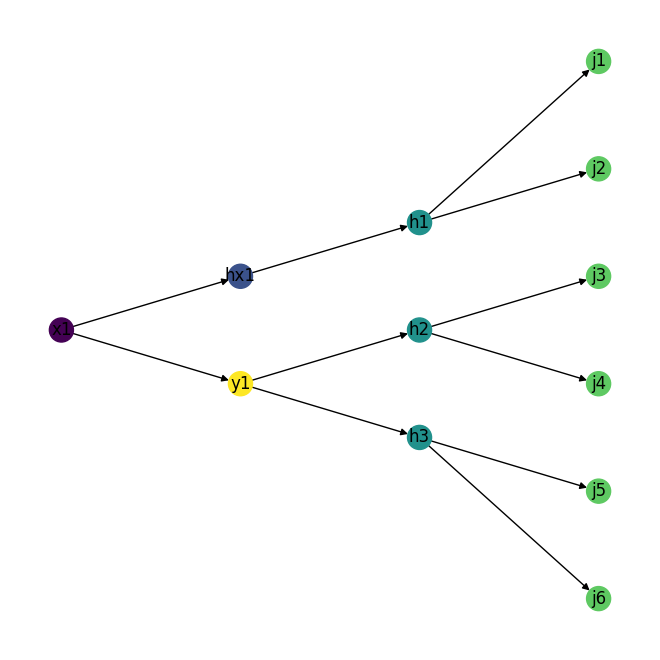

In [207]:
x_yh_3h_6j.draw_diagram()

In [208]:
for s in sig: sig.is_signal=True

100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


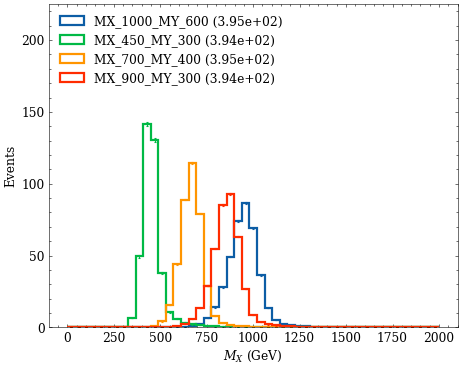

In [209]:
study.quick(
    sig,
    legend=True,
    varlist=['X_m'],
    binlist=[(0,2000,50)],
    scale=lambda t:t.dataset_norm_abs_scale,
    lumi=None,
)

In [210]:
def derive_flat_X_m(t):
    X_m = t.X_m
    h = Histo.from_array(X_m, bins=(250,2000,50))
    sf = Histo( np.where(h.histo>50, np.sum(h.histo)/h.histo, 1), bins=h.bins )
    t.flat_X_m_sf = sf

In [211]:
sig.apply(derive_flat_X_m)

[None, None, None, None]

In [212]:
def flatten_X_m(t):
    scale = t.dataset_norm_abs_scale
    sf = t.flat_X_m_sf.evaluate(t.X_m)
    norm = np.sum(scale)/np.sum(sf*scale)
    return norm*sf*scale

100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


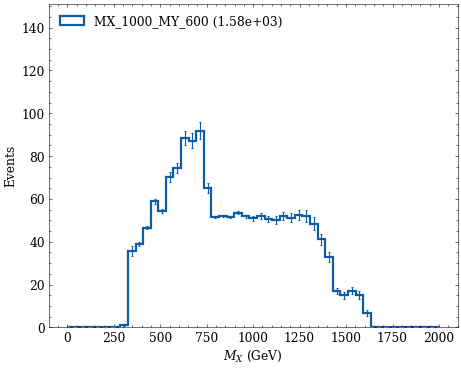

In [213]:
study.quick_region(
    sig,
    legend=True,
    varlist=['X_m'],
    binlist=[(0,2000,50)],
    scale=flatten_X_m,
    # scale=lambda t:t.dataset_norm_abs_scale,
    lumi=None,
)

100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


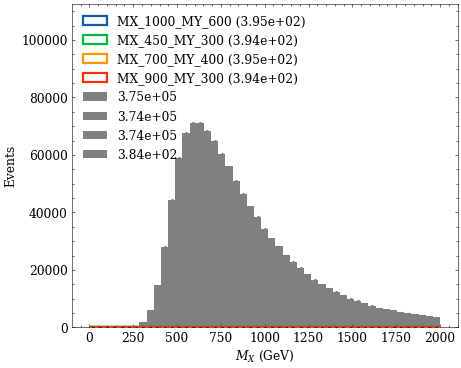

In [214]:
study.quick(
    sig+bkg,
    legend=True,
    varlist=['X_m'],
    binlist=[(0,2000,50)],
    scale=[flatten_X_m]*len(sig)+[lambda t:t.dataset_norm_abs_scale],
    # scale=lambda t:t.dataset_norm_abs_scale,
    lumi=None,
)

In [215]:
bkg_x = bkg.X_m.cat 
bkg_scale = bkg.dataset_norm_abs_scale.cat

In [216]:
sig_x = sig.X_m.cat 
sig_scale = sig.apply(flatten_X_m).cat

In [225]:
h_bkg = Histo.from_array(bkg_x, bins=(250,2000,50), weights=bkg_scale, efficiency=True, histtype='step')
h_sig = Histo.from_array(sig_x, bins=(250,2000,50), weights=sig_scale, efficiency=True, histtype='step')

bkg_sf = Histo( np.where(h_sig.raw_counts>50, h_bkg.histo/h_sig.histo, 1), bins=h_sig.bins )

sf = bkg_sf.evaluate(sig_x)

norm=np.sum(sig_scale)/np.sum(sf*sig_scale)
bkg_sf = bkg_sf.rescale(norm)

(<Figure size 650x650 with 1 Axes>, <AxesSubplot:>)

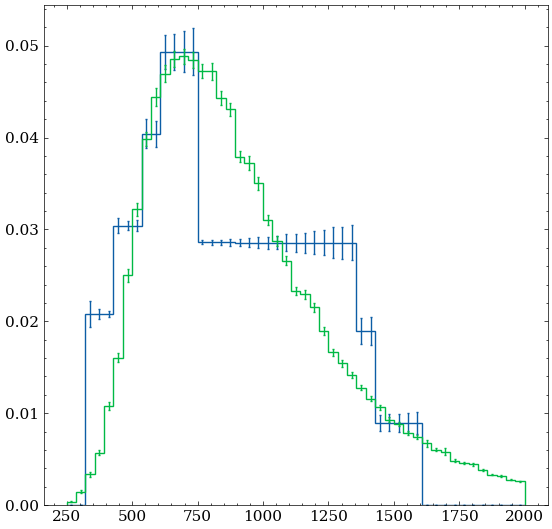

In [226]:
plot_histos([h_sig,h_bkg])

In [227]:
def bkg_X_m(t):
    scale = flatten_X_m(t)
    sf = bkg_sf.evaluate(t.X_m)
    return sf*scale

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


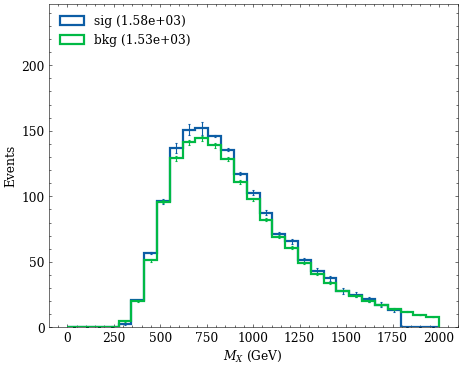

In [237]:
study.quick_region(
    sig,bkg,
    label=['sig','bkg'],
    # h_color=None,
    legend=True,
    varlist=['X_m'],
    binlist=[(0,2000,30)],
    scale=[bkg_X_m]*len(sig)+[lambda t:t.dataset_norm_abs_scale]*len(bkg),
    # scale=lambda t:t.dataset_norm_abs_scale,
    lumi=None,
)

100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


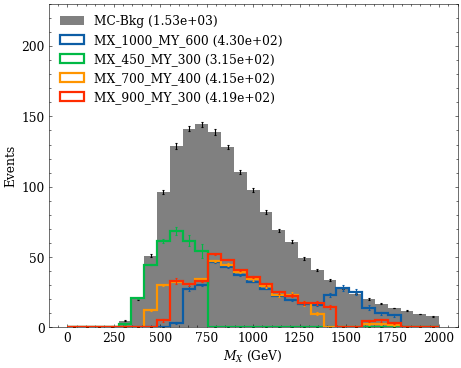

In [236]:
study.quick(
    sig+bkg,
    stack_fill=True,
    # h_color=None,
    legend=True,
    varlist=['X_m'],
    binlist=[(0,2000,30)],
    scale=[bkg_X_m]*len(sig)+[lambda t:t.dataset_norm_abs_scale]*len(bkg),
    # scale=lambda t:t.dataset_norm_abs_scale,
    lumi=None,
)